PyTorch version: 2.10.0+cpu
CUDA available: False
Loading data from Downloads/NIH Glioblastoma data.csv...
Data loaded successfully! Shape: (21634, 164)

Sample columns: ['primary_site', 'disease_type', 'updated_datetime', 'case_id', 'submitter_id', 'index_date', 'state', 'consent_type', 'project.project_id', 'demographic.ethnicity', 'demographic.gender', 'demographic.race', 'demographic.vital_status', 'demographic.age_at_index', 'demographic.submitter_id', 'demographic.days_to_birth', 'demographic.demographic_id', 'demographic.age_is_obfuscated', 'demographic.updated_datetime', 'demographic.days_to_death']

First few rows preview:
  primary_site disease_type                  updated_datetime  \
0        Brain      Gliomas  2025-01-05T15:37:46.919964-06:00   
1        Brain      Gliomas  2025-01-05T15:37:46.919964-06:00   
2        Brain      Gliomas  2025-01-05T15:37:46.919964-06:00   

                                case_id  submitter_id index_date     state  \
0  0078b0c4-68a9-483b

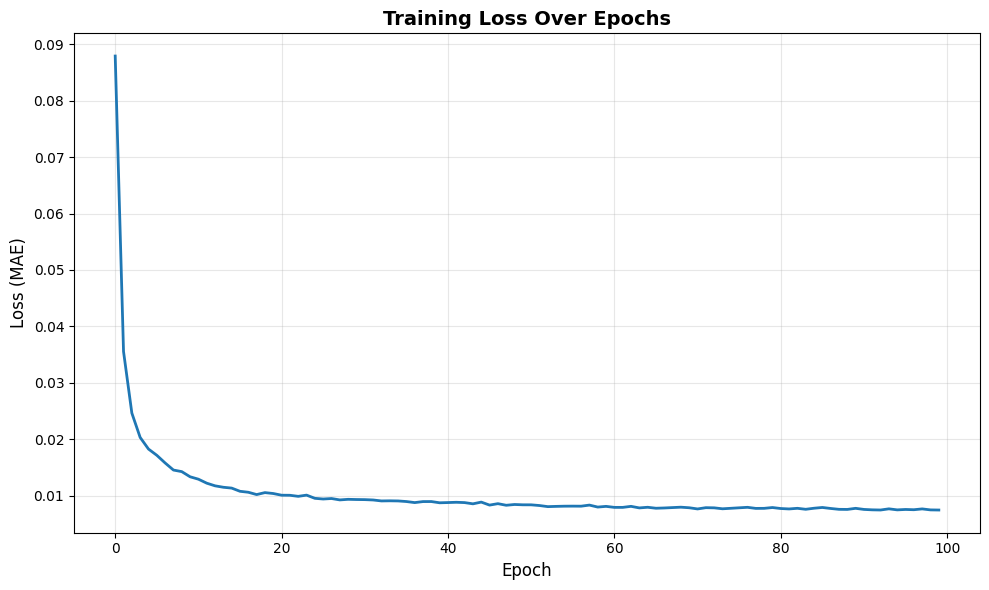

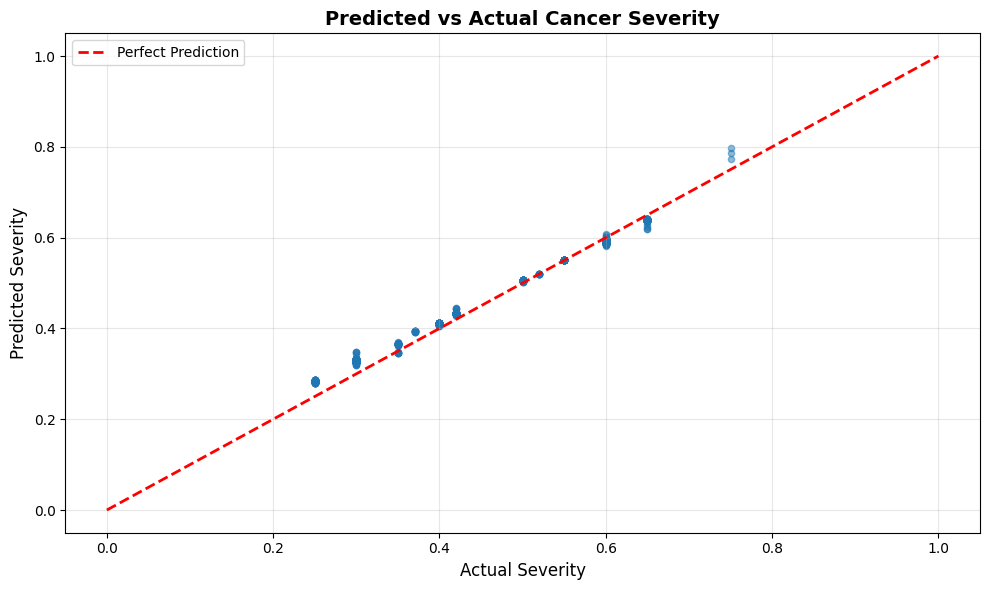

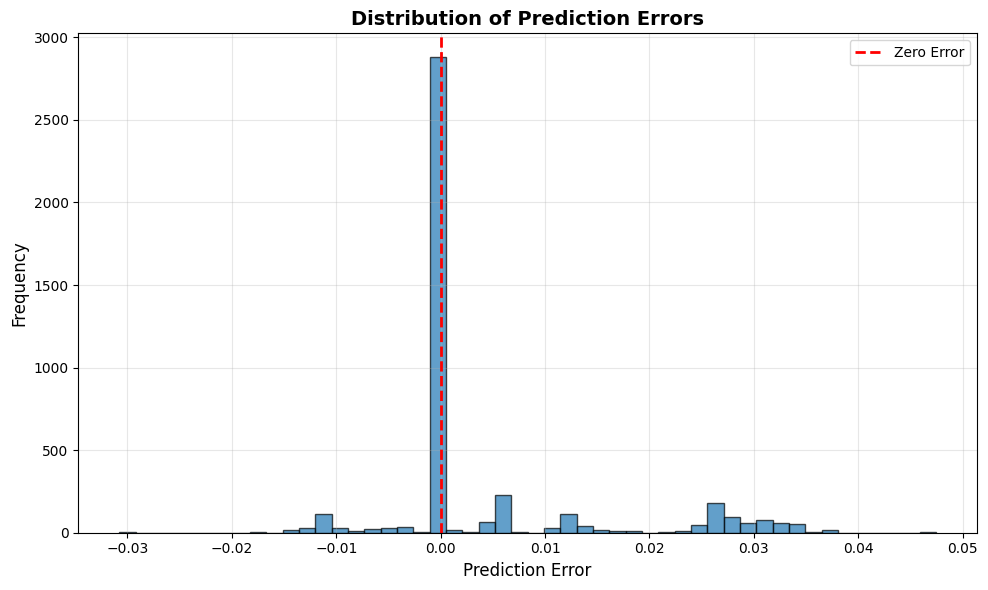


Model saved as 'medical_cancer_severity_model.pth'

Example predictions on test data:
Patient 1: Predicted=0.550, Actual=0.550, Error=0.000
Patient 2: Predicted=0.550, Actual=0.550, Error=0.000
Patient 3: Predicted=0.550, Actual=0.550, Error=0.000
Patient 4: Predicted=0.550, Actual=0.550, Error=0.000
Patient 5: Predicted=0.550, Actual=0.550, Error=0.000

Training and Evaluation Complete!


In [2]:
# Cancer Severity Prediction with PyTorch - Full Jupyter Notebook
# Medical Feedforward Neural Network for NIH Glioblastoma Data

# Cell 1: Import Libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Cell 2: Custom Dataset Class
class MedicalDataset(Dataset):
    """Custom PyTorch Dataset for medical tabular data"""
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Cell 3: Data Preprocessing Function
def preprocess_medical_data(df, create_severity=True):
    """
    Preprocesses NIH Glioblastoma medical data with categorical encoding and normalization
    """
    
    # Create severity level if it doesn't exist
    if create_severity and 'severity_level' not in df.columns:
        print("\nCreating severity_level from existing features...")
        severity = np.zeros(len(df))
        
        # Base severity on multiple factors (0-1 scale)
        # Factor 1: Tumor grade (0-0.30)
        if 'diagnoses.tumor_grade' in df.columns:
            grade_map = {'G1': 0.05, 'G2': 0.15, 'G3': 0.25, 'G4': 0.30, 'GX': 0.15}
            severity += df['diagnoses.tumor_grade'].map(grade_map).fillna(0.15)
        
        # Factor 2: Vital status (0-0.25)
        if 'demographic.vital_status' in df.columns:
            vital_map = {'Alive': 0.0, 'Dead': 0.25}
            severity += df['demographic.vital_status'].map(vital_map).fillna(0.12)
        
        # Factor 3: Metastasis (0-0.20)
        if 'diagnoses.metastasis_at_diagnosis' in df.columns:
            meta_map = {'Yes': 0.20, 'No': 0.0, 'yes': 0.20, 'no': 0.0}
            severity += df['diagnoses.metastasis_at_diagnosis'].map(meta_map).fillna(0.05)
        
        # Factor 4: Prior malignancy (0-0.15)
        if 'diagnoses.prior_malignancy' in df.columns:
            prior_map = {'Yes': 0.15, 'No': 0.0, 'yes': 0.15, 'no': 0.0}
            severity += df['diagnoses.prior_malignancy'].map(prior_map).fillna(0.05)
        
        # Factor 5: Disease status (0-0.10)
        if 'diagnoses.last_known_disease_status' in df.columns:
            status_map = {'Tumor free': 0.0, 'With tumor': 0.10, 'not reported': 0.05}
            severity += df['diagnoses.last_known_disease_status'].map(status_map).fillna(0.05)
        
        # Clip to 0-1 range
        df['severity_level'] = np.clip(severity, 0, 1.0)
        print(f"Severity level created. Range: {df['severity_level'].min():.3f} - {df['severity_level'].max():.3f}")
        print(f"Mean severity: {df['severity_level'].mean():.3f}")
    
    # Select relevant features from the NIH dataset
    feature_mapping = {
        'demographic.gender': 'gender',
        'demographic.race': 'race',
        'demographic.ethnicity': 'ethnicity',
        'diagnoses.age_at_diagnosis': 'age_at_diagnosis',
        'demographic.vital_status': 'vital_status',
        'diagnoses.tumor_grade': 'tumor_grade',
        'diagnoses.morphology': 'morphology',
        'diagnoses.site_of_resection_or_biopsy': 'site_of_biopsy',
        'diagnoses.laterality': 'laterality',
        'diagnoses.prior_malignancy': 'prior_malignancy',
        'diagnoses.prior_treatment': 'prior_treatment',
        'diagnoses.synchronous_malignancy': 'another_malignancy',
        'exposures.alcohol_history': 'alcohol_history',
        'exposures.alcohol_intensity': 'alcohol_intensity',
        'exposures.cigarettes_per_day': 'tobacco_frequency',
        'exposures.tobacco_smoking_onset_year': 'tobacco_onset',
        'diagnoses.metastasis_at_diagnosis': 'metastasis',
        'diagnoses.last_known_disease_status': 'disease_status',
        'diagnoses.progression_or_recurrence': 'progression',
        'demographic.days_to_death': 'days_to_death',
        'follow_ups.karnofsky_performance_status': 'karnofsky_score',
        'diagnoses.who_cns_grade': 'who_grade'
    }
    
    # Create a simplified dataframe with mapped columns
    df_selected = pd.DataFrame()
    for orig_col, new_col in feature_mapping.items():
        if orig_col in df.columns:
            df_selected[new_col] = df[orig_col]
    
    # Add target variable
    df_selected['severity_level'] = df['severity_level']
    
    # Remove rows where severity_level is NaN
    df_selected = df_selected.dropna(subset=['severity_level'])
    
    # Separate features and target
    X = df_selected.drop('severity_level', axis=1)
    y = df_selected['severity_level'].values.reshape(-1, 1)
    
    # Identify columns that actually exist
    existing_cols = X.columns.tolist()
    
    # Separate numerical and categorical
    numerical_cols = ['age_at_diagnosis', 'alcohol_intensity', 'tobacco_frequency', 
                      'tobacco_onset', 'days_to_death', 'karnofsky_score']
    numerical_cols = [col for col in numerical_cols if col in existing_cols]
    
    categorical_cols = [col for col in existing_cols if col not in numerical_cols]
    
    print(f"\nNumerical features: {numerical_cols}")
    print(f"Categorical features: {categorical_cols}")
    
    # Handle missing values and data cleaning
    X_processed = X.copy()
    
    # Process numerical columns
    for col in numerical_cols:
        # Convert to numeric, coercing errors to NaN
        X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')
        
        # Get non-NaN values
        non_nan_values = X_processed[col].dropna()
        
        if len(non_nan_values) > 0:
            median_val = non_nan_values.median()
            X_processed[col] = X_processed[col].fillna(median_val)
        else:
            # If all values are NaN, fill with 0
            X_processed[col] = 0
            print(f"Warning: Column '{col}' has all missing values, filled with 0")
    
    # Process categorical columns
    for col in categorical_cols:
        X_processed[col] = X_processed[col].fillna('Unknown')
        X_processed[col] = X_processed[col].astype(str)
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col])
        label_encoders[col] = le
    
    # Normalize numerical features (only if they exist and have non-zero variance)
    if numerical_cols:
        scaler = StandardScaler()
        
        # Check for constant columns (zero variance)
        for col in numerical_cols:
            if X_processed[col].std() == 0:
                print(f"Warning: Column '{col}' has zero variance, skipping normalization")
                continue
        
        # Only scale columns with variance
        cols_to_scale = [col for col in numerical_cols if X_processed[col].std() > 0]
        
        if cols_to_scale:
            X_processed[cols_to_scale] = scaler.fit_transform(X_processed[cols_to_scale])
    else:
        scaler = None
    
    # Convert to numpy array
    X_final = X_processed.values.astype(np.float32)
    
    # Check for NaN or Inf values
    if np.any(np.isnan(X_final)) or np.any(np.isinf(X_final)):
        print("Warning: Found NaN or Inf values in processed data. Replacing with 0.")
        X_final = np.nan_to_num(X_final, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Target is already 0-1, no need to normalize
    y_normalized = y
    
    print(f"\nFinal processed shape: {X_final.shape}")
    print(f"Target range: {y_normalized.min():.3f} - {y_normalized.max():.3f}")
    
    return X_final, y_normalized, label_encoders, scaler

# Cell 4: Neural Network Model Definition
class MedicalFeedforwardNN(nn.Module):
    """Feedforward Neural Network for Cancer Severity Prediction"""
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32):
        super(MedicalFeedforwardNN, self).__init__()
        
        # Layer 1: input -> hidden1
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)  # Batch normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        # Layer 2: hidden1 -> hidden2
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # Layer 3: hidden2 -> hidden3
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        # Output layer: hidden3 -> 1 (severity score)
        self.fc4 = nn.Linear(hidden_dim3, 1)
        self.sigmoid = nn.Sigmoid()  # Output between 0-1
        
        # Initialize weights properly
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        
        out = self.fc4(out)
        out = self.sigmoid(out)  # Scale to 0-1
        
        return out

# Cell 5: Training Function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=50):
    """Train the neural network model"""
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        batch_count = 0
        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Check for NaN loss
            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}, skipping batch")
                continue
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count if batch_count > 0 else float('inf')
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')
    
    return train_losses

# Cell 6: Evaluation Function
def evaluate_model(model, test_loader, device):
    """Evaluate the trained model"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features)
            
            # Values are already 0-1
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())
    
    # Calculate metrics
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals)**2))
    
    print(f'\nEvaluation Results (0-1 scale):')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Prediction range: {predictions.min():.3f} - {predictions.max():.3f}')
    print(f'Actual range: {actuals.min():.3f} - {actuals.max():.3f}')
    
    return predictions, actuals

# Cell 7: Visualization Functions
def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MAE)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(predictions, actuals):
    """Plot predictions vs actual values"""
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5, s=20)
    plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('Actual Severity', fontsize=12)
    plt.ylabel('Predicted Severity', fontsize=12)
    plt.title('Predicted vs Actual Cancer Severity', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_error_distribution(predictions, actuals):
    """Plot distribution of prediction errors"""
    errors = predictions - actuals
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    plt.xlabel('Prediction Error', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Cell 8: Main Execution - Load Data
# Replace with your CSV file path
csv_file_path = 'Downloads/NIH Glioblastoma data.csv'

try:
    # Read CSV file with low_memory=False to handle mixed types
    print(f"Loading data from {csv_file_path}...")
    df = pd.read_csv(csv_file_path, low_memory=False)
    
    print(f"Data loaded successfully! Shape: {df.shape}")
    print(f"\nSample columns: {list(df.columns[:20])}")
    print(f"\nFirst few rows preview:")
    print(df.iloc[:3, :10])
    
    # The preprocessing function will create severity_level if needed
    print("\nPreprocessing data...")
    
except FileNotFoundError:
    print(f"File '{csv_file_path}' not found. Creating synthetic data for demonstration...")
    # Create synthetic data as fallback
    np.random.seed(42)
    n_samples = 1000
    
    sample_data = {
        'demographic.gender': np.random.choice(['Male', 'Female'], n_samples),
        'demographic.race': np.random.choice(['White', 'Black', 'Asian', 'Other'], n_samples),
        'demographic.ethnicity': np.random.choice(['Hispanic', 'Non-Hispanic'], n_samples),
        'diagnoses.age_at_diagnosis': np.random.randint(20, 90, n_samples),
        'demographic.vital_status': np.random.choice(['Alive', 'Dead'], n_samples),
        'diagnoses.tumor_grade': np.random.choice(['G1', 'G2', 'G3', 'G4'], n_samples),
        'diagnoses.morphology': np.random.choice(['8000/3', '8000/6', '8010/3'], n_samples),
        'diagnoses.site_of_resection_or_biopsy': np.random.choice(['Lung', 'Breast', 'Colon', 'Prostate'], n_samples),
        'diagnoses.laterality': np.random.choice(['Left', 'Right', 'Bilateral', 'None'], n_samples),
        'diagnoses.prior_malignancy': np.random.choice(['Yes', 'No'], n_samples),
        'diagnoses.prior_treatment': np.random.choice(['Yes', 'No'], n_samples),
        'diagnoses.synchronous_malignancy': np.random.choice(['Yes', 'No'], n_samples),
        'exposures.alcohol_history': np.random.choice(['Yes', 'No', 'Former'], n_samples),
        'exposures.alcohol_intensity': np.random.randint(0, 10, n_samples),
        'exposures.cigarettes_per_day': np.random.randint(0, 40, n_samples),
        'exposures.tobacco_smoking_onset_year': np.random.randint(1950, 2020, n_samples),
        'diagnoses.metastasis_at_diagnosis': np.random.choice(['Yes', 'No'], n_samples),
        'diagnoses.last_known_disease_status': np.random.choice(['Tumor free', 'With tumor', 'not reported'], n_samples),
        'diagnoses.progression_or_recurrence': np.random.choice(['Yes', 'No'], n_samples),
        'demographic.days_to_death': np.random.randint(0, 3650, n_samples),
    }
    
    df = pd.DataFrame(sample_data)

# Cell 9: Preprocess Data
X, y, encoders, scaler = preprocess_medical_data(df, create_severity=True)

print(f"\nProcessed data shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# Cell 10: Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Cell 11: Create DataLoaders
train_dataset = MedicalDataset(X_train, y_train)
test_dataset = MedicalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Cell 12: Initialize Model
input_dim = X.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MedicalFeedforwardNN(input_dim).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nDevice: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Cell 13: Define Loss Function and Optimizer
# Using L1Loss (MAE) for more readable loss values
criterion = nn.L1Loss()  # Mean Absolute Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

# Cell 14: Train the Model
print("\n" + "="*60)
print("Training Medical Cancer Severity Prediction Model...")
print("="*60)

train_losses = train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

# Cell 15: Evaluate the Model
predictions, actuals = evaluate_model(model, test_loader, device)

# Cell 16: Visualize Results
print("\nGenerating visualizations...")

# Plot 1: Training loss
plot_training_loss(train_losses)

# Plot 2: Predictions vs Actual
plot_predictions_vs_actual(predictions, actuals)

# Plot 3: Error distribution
plot_error_distribution(predictions, actuals)

# Cell 17: Save the Model
model_path = 'medical_cancer_severity_model.pth'
torch.save(model.state_dict(), model_path)
print(f"\nModel saved as '{model_path}'")

# Cell 18: Example - Make Predictions on New Data
def predict_severity(model, new_data, device):
    """Make predictions on new patient data"""
    model.eval()
    with torch.no_grad():
        new_data_tensor = torch.FloatTensor(new_data).to(device)
        prediction = model(new_data_tensor)
        return prediction.cpu().numpy()

# Example usage (using first 5 test samples)
print("\nExample predictions on test data:")
sample_data = X_test[:5]
sample_predictions = predict_severity(model, sample_data, device)

for i, (pred, actual) in enumerate(zip(sample_predictions, y_test[:5])):
    print(f"Patient {i+1}: Predicted={pred[0]:.3f}, Actual={actual[0]:.3f}, Error={abs(pred[0]-actual[0]):.3f}")

print("\n" + "="*60)
print("Training and Evaluation Complete!")
print("="*60)
# csv_file_path = 'Downloads/NIH Glioblastoma data.csv'